In [187]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Sequential, Model

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

np.random.seed(12211)  

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_train

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [188]:
train_mode = True # False if you don't want to train again

In [273]:
num_train = 9999 # 10000, 4000 # Max: 200000 
num_test = 1000 # 1000 # Max: 20000

In [274]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6] # Soon there will be more!
# Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][3]
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7] # Test on the same things we tested before (SDSS)

In [275]:
# Hyperparameters
n_epochs = 20 # 100
D = 5 #6  # number of features (in input space)
K = 3 #16 # number of mixture components # a "component" of a GMM is one gaussian, right?

learning_rate = 1e-4
decay_rate= 1e-3
batch_size = 1024

# Here we define hyperparameters!
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [276]:
X_train, y_train, _, _ = help_train.loadTrainTest_july(dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Data/fromGalaxev/photozs/datasets/data_july_2020/')
X_test, y_test, X_err, label_test = help_train.loadTest(Testset, dirIn = '/data/a/cpac/aurora/MDN_phoZ/Data/fromGalaxev/photozs/datasets/data_feb_2021/') # data_feb_2021

----------
number of datapoints:  187462
z-minmax:  0.0020016062 1.249997
ColMag-min:  [-0.09145837 -0.05327791 -0.02479261 -0.10519464 12.000012  ]
ColMag-max:  [ 3.825315   2.8303378  1.6937237  1.5019817 23.499979 ]
----------
----------
number of datapoints:  10322
z-minmax:  0.0020014732 1.249283
ColMag-min:  [-4.1676056e-02 -7.1866615e-03  5.6203555e-02 -6.4645730e-02
  1.2003667e+01]
ColMag-max:  [ 3.6190994  2.7985296  1.6097487  1.4396983 23.4981   ]
----------
----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188479   -3.8901405  -2.1034117 -15.92296    12.114799 ]
ColMag-max:  [17.02884   7.925968  4.182415  2.264679 25.709858]
----------


In [277]:
X_train, y_train, X_trainShuffleOrder = help_train.shuffle(X_train, y_train) # literally just shuffle the data
# X_test, y_test, label_test, X_testShuffleOrder = shuffleOBS(X_test, y_test, test_labels) # Why aren't we doing this?

In [278]:
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5 # Same as what we got from print_limits
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.0 #np.min(y_train)
max_z = 1.1 #np.max(y_train)

mins_and_maxs = [min_col, max_col, min_mag, max_mag, min_z, max_z]

X_test, y_test, label_test, mask_cond = help_train.minmax_cutsOBSarr(X_test, y_test, label_test, mins_and_maxs) # Make sure all our data falls within the desired range (and bins)

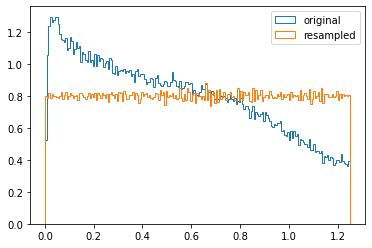

(79600,)


In [279]:
# Notice, this cell is recursive. (If you run it multiple times, the resulting plot will change)
resampleTrain = True
n_bins = 200 
select_per_bin = 400 # 500, 50

if resampleTrain:
    X_train, y_train, resampled_ind = help_train.resample(X_train, y_train, n_bins, select_per_bin) # What is "rest"? And where did the original data go?

In [280]:
print("Size of features in training data: {}".format(X_train.shape)) # what do we mean features?
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (79600, 5)
Size of output in training data: (79600,)
Size of features in test data: (2767, 5)
Size of output in test data: (2767,)


In [281]:
# Previously, we said "this notebook doesn't train models, it deploys them"
# Now, we are training models (I think?)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

# This preproc stuff is related to "scaling routine" -- right? Yes :)
preproc = Pipeline([('stdscaler', StandardScaler())]) # This preproc tool is what allows us to transform inputs into min-max space (and therefore to feed it to the trained model)
# preproc = Pipeline([('stdscaler', MinMaxScaler())])
X_train = preproc.fit_transform(X_train) # Not sure how "fit_transform" is different from the original "transform"?

scalerfile = save_mod + '_scaling_X'
pickle.dump(preproc, open(scalerfile, 'wb'))
preproc = pickle.load(open(scalerfile, 'rb'))

X_test = preproc.transform(X_test) # This transformation puts our input into min-max space

# preproc_y = Pipeline([('stdscaler', StandardScaler())])
preproc_y = Pipeline([('stdscaler', MinMaxScaler())])

y_train = preproc_y.fit_transform(y_train.reshape(-1, 1))

scalerfile = save_mod + '_scaling_y'
pickle.dump(preproc_y, open(scalerfile, 'wb'))
preproc_y = pickle.load(open(scalerfile, 'rb'))

y_test = preproc_y.transform(y_test.reshape(-1, 1))

In [282]:
help_train.print_limits(X_train, y_train)

help_train.print_limits(X_test, y_test)

----------
number of datapoints:  79600
z-minmax:  0.0 1.0000001
ColMag-min:  [-1.6531353 -2.2798522 -2.3279574 -2.2450078 -4.2344937]
ColMag-max:  [4.767169  4.2191896 3.5247087 3.9675057 1.2646018]
----------
----------
number of datapoints:  2767
z-minmax:  -0.0015975338 0.8793446
ColMag-min:  [-1.6406589 -2.2354624 -2.3151824 -2.2963026 -4.179605 ]
ColMag-max:  [4.766438  4.1601014 3.6088161 3.9107807 1.025395 ]
----------


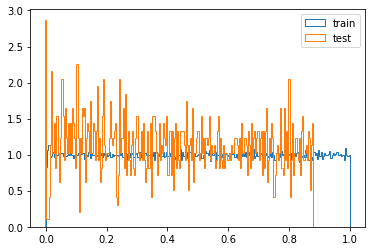

In [283]:
# That is a very messy histogram :P Looks like the precision on test is much lower than on train?
plt.figure(23)

plt.hist(y_train, density=True, bins = 250, histtype='step', label='train')
plt.hist(y_test, density=True, bins = 250, histtype='step', label='test')
plt.legend()
plt.savefig("precision" + str(num_train) + ".png")

In [284]:
class PrintLR(tf.keras.callbacks.Callback): # Print learning rate at every epoch
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model_train.optimizer.lr.numpy()))

In [285]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay_rate),
    PrintLR()
]

In [286]:
# These are the network parameters!! (This whole cell is network architecture)

# x = tf.keras.layers.InputLayer(input_shape=(D,)),
non_lin_act = tf.nn.relu #tf.nn.tanh
y_true = tf.keras.Input(shape=(1,))
inputs = tf.keras.Input(shape=(D,))
layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)

In [287]:
model_train = Model([inputs, y_true], [mu, var, pi], name='mdn') # Previously, this was the mixed density model (is that the same as a Gaussian mixture model?)

In [288]:
# Define custom loss
def custom_loss(layer):
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true, mu, var, pi):
        mixture_distribution = tfp.distributions.Categorical(probs=pi)
        distribution = tfp.distributions.Normal(loc=mu, scale=var)
        likelihood = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture_distribution,components_distribution=distribution)

        log_likelihood = -1.0*likelihood.log_prob(tf.transpose(y_true)) # A little confusing (talk later)
        mean_loss = tf.reduce_mean(log_likelihood)

        return mean_loss  
    return loss
    
model_train.add_loss(custom_loss(inputs)(y_true, mu, var, pi))
model_train.compile(optimizer='Nadam')
model_train.summary()

Model: "mdn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_108 (Dense)               (None, 512)          3072        input_26[0][0]                   
__________________________________________________________________________________________________
dense_109 (Dense)               (None, 1024)         525312      dense_108[0][0]                  
__________________________________________________________________________________________________
dense_110 (Dense)               (None, 2048)         2099200     dense_109[0][0]                  
________________________________________________________________________________________________

In [289]:
%%time
if train_mode:

    history = model_train.fit([X_train, y_train], validation_split = 0.1, epochs=n_epochs, batch_size = batch_size, callbacks=callbacks) # What's this history about?
    # The problem is in the above line
    model_train.save_weights(save_mod + '.h5')
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)

TypeError: 'float' object is not callable

In [290]:
model_train.load_weights(save_mod + '.h5') # Previously, this exact line was loading the weights of (from?) the mixed density model

OSError: Unable to open file (unable to open file: name = 'saved_hubs/tf2models/Train_UMnew_lr_0.0001_dr0.001_ne20_k3_nt9999.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [291]:
y_pred = np.array(model_train(X_test))

y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))

In [292]:
y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :]) # Previously, we used preproc_y to pick the best Gaussian (of the three that make up the Gaussian mixture model)
y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
y_pred_3weights = y_pred[2, :, :]

y_test_all = preproc_y.inverse_transform(y_test)


predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights])
truelabel = np.array([y_test_all[:, 0], label_test])

np.save(save_mod+'test_true', predstdweights )
np.save(save_mod+'test_pred', truelabel )

[<matplotlib.lines.Line2D object at 0x7f6564099990>, <matplotlib.lines.Line2D object at 0x7f64fc229f10>, <matplotlib.lines.Line2D object at 0x7f64fc229990>, <matplotlib.lines.Line2D object at 0x7f658c4bb650>, <matplotlib.lines.Line2D object at 0x7f65400bc5d0>, <matplotlib.lines.Line2D object at 0x7f658c4bbb90>, <matplotlib.lines.Line2D object at 0x7f65645e0d50>, <matplotlib.lines.Line2D object at 0x7f64fc17dc50>, <matplotlib.lines.Line2D object at 0x7f64fc17dad0>, <matplotlib.lines.Line2D object at 0x7f64fc17d5d0>]


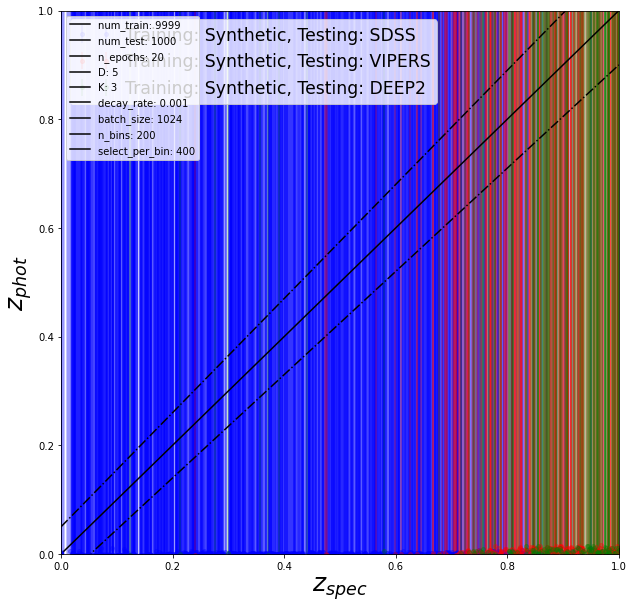

<Figure size 720x720 with 0 Axes>

In [293]:
ifPlotWeighted = True
y_pred_mean_best = y_pred_mean # So I've never understood this part. How do we know it's the best? And if it's always been the best, why didn't we call it the best from the beginning?
y_pred_std_best = y_pred_std   # No good answer ;) 

fig, ax = plt.subplots(figsize=(10, 10,)) # How does this work (or conflict) with plt.figure() down below?
if ifPlotWeighted:

    colorstring = ['b', 'r', 'g', 'k', 'orange']
    surveystring = ['SDSS', 'VIPERS', 'DEEP2']

    plt.figure(22, figsize=(10, 10,))

    C = 0.05
    z_t = np.array([0, 1])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)

    ax.plot(z_t, z_t, 'k')
    ax.plot(z_t, z_tp, 'k-.')
    ax.plot(z_t, z_tm, 'k-.')

    for label_ind in [0, 1, 2]:
        surveyindx = np.where(label_test == label_ind)
        offset = 0.0
        
        ax.errorbar(preproc_y.inverse_transform(y_test)[surveyindx][:, 0], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0], yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0], fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind], c = colorstring[label_ind])

ax.set_ylabel(r'$z_{phot}$', fontsize=25)
ax.set_xlabel(r'$z_{spec}$', fontsize=25)
        
ax.set_xlim(0.0, 1)
ax.set_ylim(0.0, 1)

plt.tight_layout()
# plt.axes().set_aspect('equal')

leg1 = ax.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)
fake_lines = [ax.plot([], [], c = "black")[0] for i in range(0,10)]
print(fake_lines)
param_labels = ["num_train: " + str(num_train), "num_test: " + str(num_test), "n_epochs: " + str(n_epochs), "D: " + str(D), "K: " + str(K), "decay_rate: " + str(decay_rate), "batch_size: " + str(batch_size), "n_bins: " + str(n_bins), "select_per_bin: " + str(select_per_bin)]
ax.legend(handles = fake_lines, labels = param_labels, loc = "upper left")
ax.add_artist(leg1)
#fig.savefig('phoz_compare_surveys_numtrain_' + str(num_train) + '.pdf', bbox_inches='tight')
fig.savefig("phoz_ntrain" + str(num_train) + ".png")
fig.show()
# num train, num test, n epochs, D, K, learning rate, decay rate, batch size, nbins, select per bin